# Exchange Spectroscopy (EXSY)

In this first example, we simulate a system where the chemical shift exchanges between two frequencies according to an exchange matrix. We will then look how it results in a 2D EXSY spectrum, and how that spectrum changes as a function of a mixing time.

In [53]:
#!git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [54]:
%matplotlib notebook

## Build the system
The first step is to build the system, which will have a single nucleus, with two different chemical shifts, and export this sytem into Liouville space, allowing us to introduce an exchange process

In [55]:
ex0=RS.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
ex1.set_inter(Type='CS',i=0,ppm=5)

L=RS.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

## Add the exchange process
We'll define a correlation time and population 1 and population 2. From this we can build the exchange matrix and append it to the Liouvillian. We also add some T2 relaxation to destroy transverse magnetization during the delay period for exchange and produce some broadening.

In [56]:
tc=1     #Correlation time (1 s)
p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2

kex=np.array([[-1/(2*tc),1/(2*tc)],[1/(2*tc),-1/(2*tc)]])+np.array([[-(p2-p1)/2,(p1-p2)/2],[(p2-p1)/2,-(p1-p2)/2]])
L.kex=kex

L.add_relax(Type='T2',i=0,T2=.05)

We can check the correlation time and equilibrium populations based on eigenvalue decomposition of the exchange matrix

In [57]:
d,v=np.linalg.eig(kex)
i=np.argsort(d)  # One element should be zero, the other negative
tc_k=-1/d[i[0]]
peq=v[:,i[1]]
peq/=peq.sum()
print(f'The correlation time is {tc_k:.1f} s, and the equilibrium populations are ({peq[0]:.2f},{peq[1]:.2f})')

The correlation time is 1.0 s, and the equilibrium populations are (0.75,0.25)


## Run as a 2D experiment
First, we'll just calculate one 2D spectrum, and then later check how the spectrum evolves as a function of a delay time. We need an initial density matrix, $S_x$, a detection matrix, $S^+$, and propagators for evolution times, $\pi$/2 pulses, and a delay for the exchange process. We start with generating the propagators and density matrices.

In [58]:
rho=RS.Rho(rho0='S0x',detect='S0p')
Dt=1/(2*10*150)  #For a 10 ppm shift difference, this should be enough to easily capture both peaks in the spectrum 
Uevol=L.U(Dt=Dt)  #Propagator for the evolution time
pi2x=RS.Sequence(L=L) #Pulse sequences for pi/2 pulses
pi2y=RS.Sequence(L=L)
pi2my=RS.Sequence(L=L)
pi2x.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=0)      #Here we add the pi/2 pulse on x
pi2y.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=np.pi/2) #Here we add the pi/2 pulse on y
pi2my.add_channel('13C',t=[0,2.5e-6],v1=100000,phase=-np.pi/2) #Here we add the pi/2 pulse on y
Upi2x=pi2x.U()  #Get the propagators for the pulse sequence
Upi2y=pi2y.U()
Upi2my=pi2my.U()
Udely=L.U(Dt=5) #Get the propagator for the delay (Here set to 5 seconds, i.e. full exchange)

## Execute the sequence
We need to capture both an indirect and direct dimension, with both real and imaginary components. We'll loop over the indirect dimension, and capture the direct dimension with Rho.DetProp

In [59]:
RE=list()
IM=list()
n=256
for k in range(n):
    rho.clear()
    #First capture the real part
    Uevol**k*rho  #This applies the evolution operator n times
    Upi2my*rho     #This flips the x magnetization up to z
    Udely*rho     #This applies the delay for exchange to occur
    Upi2y*rho    #The flips the z magnetization back to x
    rho.DetProp(Uevol,n=n) #Detect the transverse (S0p) magnetization
    RE.append(rho.I[0])
    #Now capture the imaginary part
    rho.clear()
    Uevol**k*rho
    Upi2x*rho #Flip the y magnetization up to z
    Udely*rho
    Upi2y*rho #Flip z magnetization back to x
    rho.DetProp(Uevol,n=n)
    IM.append(rho.I[0])

## Fourier transform and plot the results
We just extract the real part from the spectrum

In [63]:
RE,IM=np.array(RE,dtype=complex),np.array(IM,dtype=complex)
spec=np.fft.fftshift(np.fft.fft(np.fft.fft(RE,n=2*n,axis=1).real+1j*np.fft.fft(IM,n=2*n,axis=1),n=2*n,axis=0),axes=[0,1])
v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])  #Frequency axis
v-=(v[1]-v[0])/2  
v/=ex0.v0[0]*1e6   #convert to ppm
vx,vy=np.meshgrid(v,v)  #meshgrid for plotting

<IPython.core.display.Javascript object>


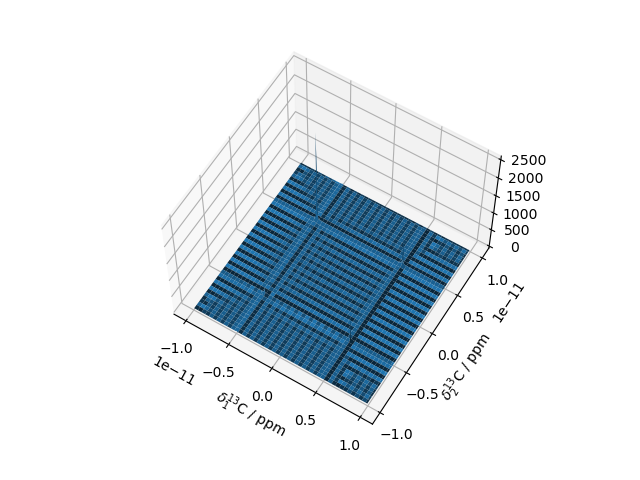

/Users/albertsmith/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1813: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/albertsmith/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1814: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/albertsmith/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$\\delta_2 ^{13}$C / ppm')

In [64]:
ax=plt.figure().add_subplot(111,projection='3d')
ax.plot_surface(vx,vy,spec)
ax.set_xlabel(r'$\delta_1 ^{13}$C / ppm')
ax.set_ylabel(r'$\delta_2 ^{13}$C / ppm')

In [42]:
spec.shape

(512, 512)

In [43]:
v.shape

(2, 2)

In [44]:
v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])
v-=(v[1]-v[0])/2

In [45]:
v.shape

(512,)